# Model Customer Churn

## Please read before running
End to end runtime for the script is around 50 minutes. 

Data imported from GitHub repository\
Two CSVs\
CSV 1: country_table holds labels for country IDs \
CSV 2: customer_attribute holds customer level data including, join date, gender, age, country ID, contact propensity & churn flag\

Author: John Ade-Ojo \
Date Created 13/02/2021 \
GitHub Repo: https://github.com/john-adeojo/ChurnModelling

In [1]:
import time

# Record script start time
script_start_time = time.process_time()

In [2]:
# Pull in Data from GitHub repository
import numpy as np
import pandas as pd


def read_file(url):

    """
    Takes GitHub url as an argument,
    pulls CSV file located @ github URL.

    """

    url = url + "?raw=true"
    df = pd.read_csv(url, encoding="utf-8")
    return df


# READ FILE FROM GITHUB REPO
url = "https://github.com/john-adeojo/ChurnModelling/blob/main/country_table.csv"
country = read_file(url)
url = "https://github.com/john-adeojo/ChurnModelling/blob/main/customer_attribute.csv"
customer_a = read_file(url)

# Data Preparation 
1) Create *customers* by joining *country* and *customer_a* to pull in names of the country of residence.
2) Split out *join_date* into *join_year* and *join_month*.
3) Split out *customers* into *test* and *train* by *churn_flag* = *NA*.
4) Check *test* and *train* for missing or unknown values and handle approprately.



In [3]:
import calendar

# Create customers table by joining on country id
customers = pd.merge(customer_a, country, how="left", on="country_id").drop(
    columns="country_id"
)

# Convert date to datetime
customers.join_date = pd.to_datetime(customers.join_date, utc=True)

# Split out join_date two create join_month & join_year
customers["join_year"] = customers.join_date.dt.year
customers["join_month"] = customers.join_date.dt.month

# Converts month number to month name for convenience
customers.join_month = customers.join_month.apply(lambda x: calendar.month_name[x])

# Split customer data into test train by churn flad = na
test = customers.loc[customers.churn_flag.isna() == True].copy()
train = customers.loc[customers.churn_flag.isna() == False].copy()

# Drop churn flag from test data set
print("Training set size:", train.shape, "Testing set size:", test.shape)

Training set size: (50598, 9) Testing set size: (5622, 9)


In [4]:
# Check for missing observations
print("Training Data Info")
train.info()

Training Data Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50598 entries, 0 to 56219
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   customer_id         50598 non-null  object             
 1   gender              50598 non-null  object             
 2   join_date           50598 non-null  datetime64[ns, UTC]
 3   age                 50598 non-null  int64              
 4   contact_propensity  50598 non-null  float64            
 5   churn_flag          50598 non-null  float64            
 6   country_name        50598 non-null  object             
 7   join_year           50598 non-null  int64              
 8   join_month          50598 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(4)
memory usage: 3.9+ MB


In [5]:
# Check for missing observations
print("Testing Data Info")
test.info()

Testing Data Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5622 entries, 24 to 56211
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   customer_id         5622 non-null   object             
 1   gender              5622 non-null   object             
 2   join_date           5622 non-null   datetime64[ns, UTC]
 3   age                 5622 non-null   int64              
 4   contact_propensity  5622 non-null   float64            
 5   churn_flag          0 non-null      float64            
 6   country_name        5622 non-null   object             
 7   join_year           5622 non-null   int64              
 8   join_month          5622 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(4)
memory usage: 439.2+ KB


# Exploratory Data Analysis
The *train* data set are the examples that will feed the ML algorithms. Machine learning will be effective if the training set is\
is representative of the test set. This is usually done by choosing the appropriate sampling strategy.


## Unsual Obersavtions 
Initial univariate analysis has shown us that there are some weird quirks in the data which are most likely data quality issues.\
Testing set: One customer is identified as being 150 years old which is highly improbable.\
Training set: Some customers have a join date of 1901, very unlikely.\
Training & Testing: There are 3 unique values for gender in the training and testing data.\

We can either discard these weird reults or recreate them through interpolation. 
Both options have pros and cons. Interpolation could bias our data sample whereas discarding observations leads to loss of information. 
Because there are 14,329 churn cases in our training set and 36,266 non-churn, I will discard observations in the training set that are\
missing in low volumes.

### Missing & unknown countries
There are 6 customers whose current country of residence is missing and a further 6 wthat are unknown. Due to the low volumes I'll omit these\
cases from the training data.

### Join date 1901
There are only 3 observations with this unusal join date and they're in the training set. These are discarded.\

### Very very old customer
This is likely a data input error that could occur with future unknown test cases.\
I handle this by interpolating customers age as the mode age for the customers in that customers country.\
I'll make the assumption that  if a customer is above 117 then interpolate to the mode. I've used 117 as this\
is the age of the current oldest living person.

### The third gender
I assume that U are people that have chosen not to reveal there gender\
In this case, there's probably no need to interpolate because customers\
that have chosn not to reveal their gender might behave differently to those that have. 


In [6]:
# Look at descriptive statistic for test set
print("Testing Set")
test.describe(include="all")

Testing Set


,customer_id,gender,join_date,age,contact_propensity,churn_flag,country_name,join_year,join_month
count,5622,5622,5622,5622.000000,5622.000000,0.0,5622,5622.000000,5622
unique,5622,3,1030,NaN,NaN,NaN,5,NaN,12
top,WR10001062,M,2020-04-27 00:00:00+00:00,NaN,NaN,NaN,United Kingdom,NaN,June
freq,1,3351,27,NaN,NaN,NaN,1664,NaN,750
first,NaN,NaN,2015-02-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-07-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,45.501067,0.190164,NaN,NaN,2019.238171,NaN
std,NaN,NaN,NaN,11.884365,0.140620,NaN,NaN,0.871180,NaN
min,NaN,NaN,NaN,19.000000,0.000000,NaN,NaN,2015.000000,NaN
25%,NaN,NaN,NaN,35.000000,0.077465,NaN,NaN,2019.000000,NaN


In [7]:
# Look at descriptive statistics for train set
print("Training Set")
train.describe(include="all")

Training Set


,customer_id,gender,join_date,age,contact_propensity,churn_flag,country_name,join_year,join_month
count,50598,50598,50598,50598.000000,50598.000000,50598.000000,50598,50598.000000,50598
unique,50598,3,1664,NaN,NaN,NaN,7,NaN,12
top,WR10009842,M,2020-06-28 00:00:00+00:00,NaN,NaN,NaN,United Kingdom,NaN,June
freq,1,30393,185,NaN,NaN,NaN,15003,NaN,6700
first,NaN,NaN,1901-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-11-29 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,45.593245,0.192091,0.283213,NaN,2019.234792,NaN
std,NaN,NaN,NaN,11.853492,0.146092,0.450563,NaN,1.268542,NaN
min,NaN,NaN,NaN,-99.000000,0.000000,0.000000,NaN,1901.000000,NaN
25%,NaN,NaN,NaN,35.000000,0.076113,0.000000,NaN,2019.000000,NaN


In [8]:
# Let's check for missing data
print("Train Information")
train.info()

print("Test Information")
test.info()

Train Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50598 entries, 0 to 56219
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   customer_id         50598 non-null  object             
 1   gender              50598 non-null  object             
 2   join_date           50598 non-null  datetime64[ns, UTC]
 3   age                 50598 non-null  int64              
 4   contact_propensity  50598 non-null  float64            
 5   churn_flag          50598 non-null  float64            
 6   country_name        50598 non-null  object             
 7   join_year           50598 non-null  int64              
 8   join_month          50598 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(4)
memory usage: 3.9+ MB
Test Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5622 entries, 24 to 56211
Data columns (total 9 co

In [9]:
# Commented out to tidy up output

# Look at gender break down frequency
#print("Gender break down frequency: Training")
#print(train.gender.value_counts())

#print("Gender break down frequency: Testing")
#print(test.gender.value_counts())

# Look at country break down frequency
#print("Gender break down frequency: Training")
#print(train.country_name.value_counts())

#print("Gender break down frequency: Testing")
#print(test.country_name.value_counts())


# Look at join month  break down frequency
#print("Gender break down frequency: Training")
#print(train.join_month.value_counts())

#print("Gender break down frequency: Testing")
#print(test.join_month.value_counts())

# Look at churn_flag  break down frequency
#print("Gender break down frequency: Training")
#print(train.churn_flag.value_counts())

In [10]:
# Commented out to tiday up output
# Pulls out weird results Testing:
#print(test.loc[test.age > 100])

# Pulls out  weird results Train:
#print(train.loc[train.join_year < 2010])

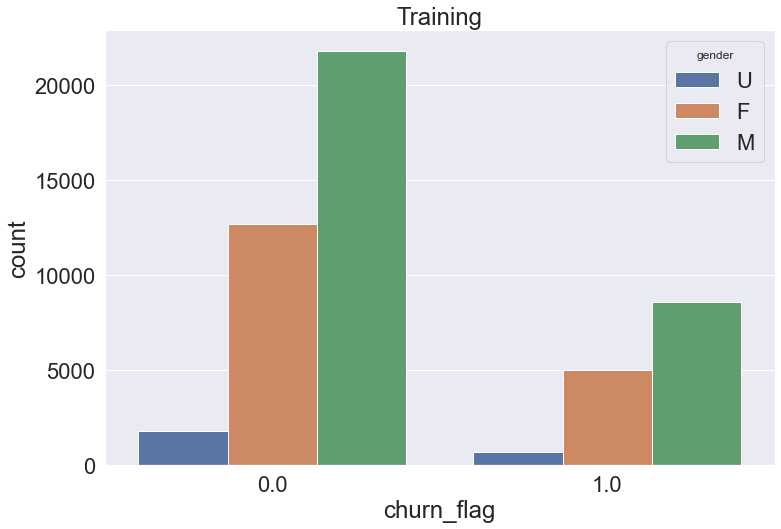

In [11]:
# Lets see how gender is distirbuted across by churn status
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Plot gendr distirbutions accross churn flags
sns.set(font_scale=2)
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
ax = sns.countplot(x=train["churn_flag"], hue=train["gender"])
ax.set_title("Training")
plt.savefig("Churn_flaggen")
plt.show()

In [12]:
# Reomve customers with join year of 1901
train = train.loc[train.join_year > 2010]

# Omitt missing & unknown country_name
train = train.loc[(train.country_name != "Missing") & (train.country_name != "Unknown")]

# Replace old customers with NA
test.loc[test.age > 117, "age"] = np.nan
# Fill NA with group means by country name
test["age"] = test["age"].fillna(test.groupby("country_name")["age"].transform("mean"))


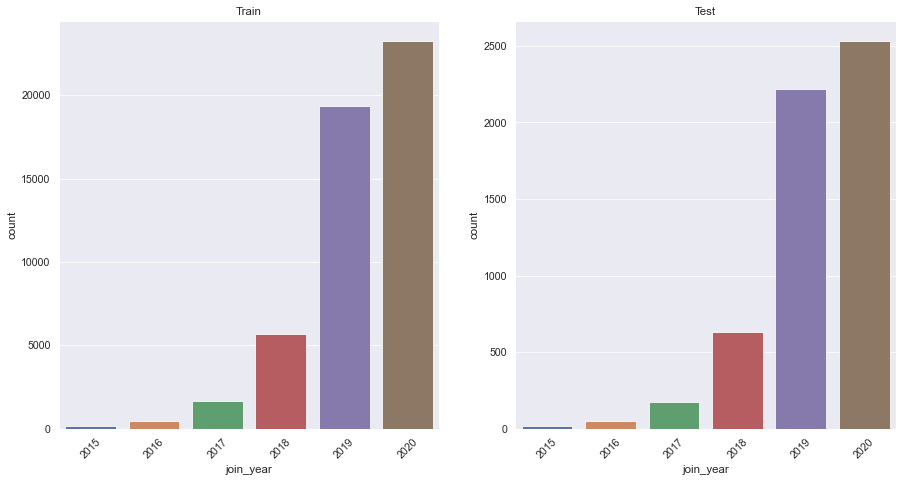

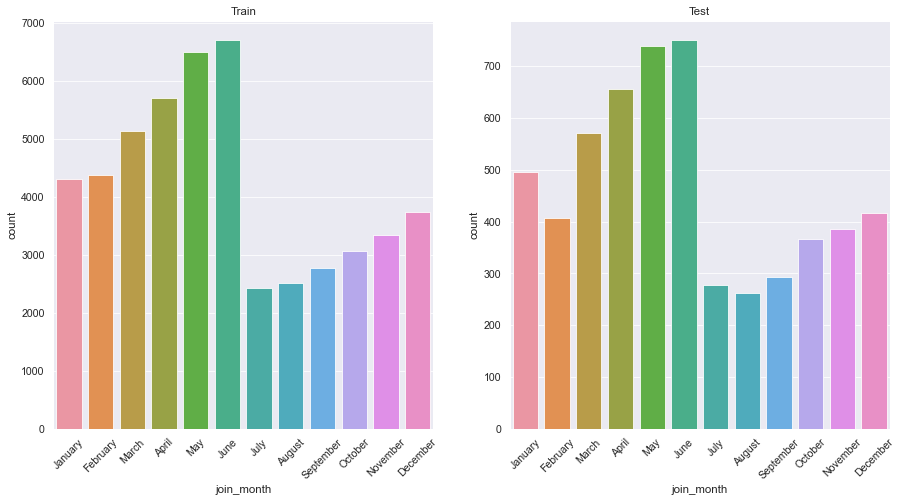

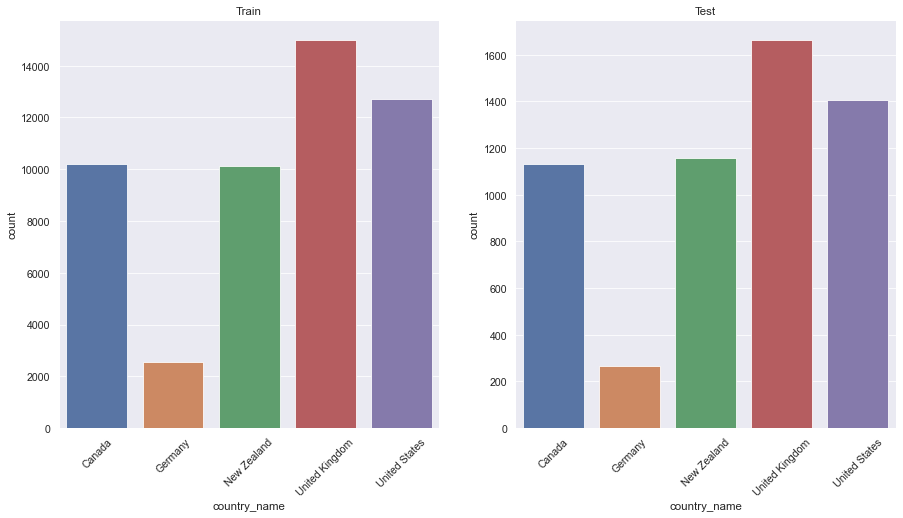

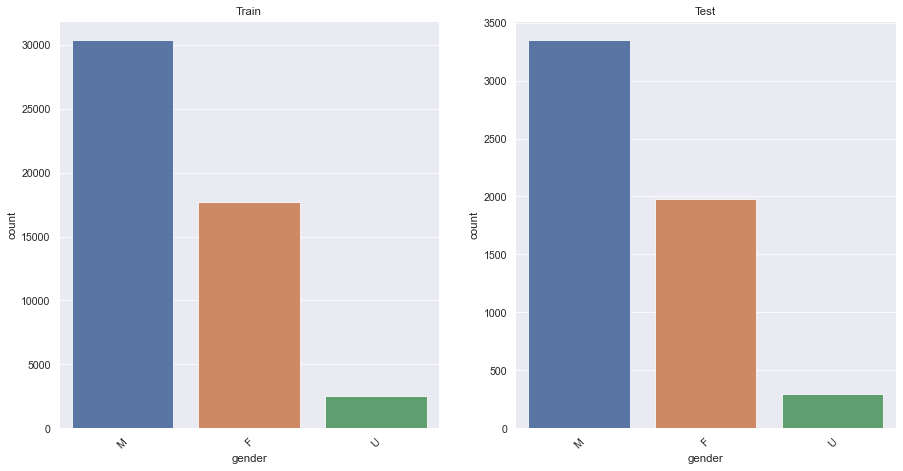

In [13]:
# Define a function to plot distributions
def histogram(train_data, test_data, x, order):
    """
    plots histograms for test and train data side by side
    
    train_data: pandas data frame (test or train)
    test_data: pandas data frame (test or train)
    
    title: title of plot, as str
    x: analysis vairable should be name of column with type object
    order: list of str tnat must match x-axis labels for analysis
    variable
    
    """

    x_col = train_data[x]
    x2_col = test_data[x]

    sns.set_style(style="darkgrid")
    sns.color_palette("pastel")
    sns.set_context("paper", font_scale=1.2)

    # Set frame of two plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))

    # Generate two count plots on the same frame
    sns.countplot(x=x_col, ax=ax[0], order=order)
    sns.countplot(x=x2_col, ax=ax[1], order=order)

    # Label give each plot a title
    ax[0].set_title("Train")
    ax[0].tick_params(axis="x", labelrotation=45)
    ax[1].set_title("Test")
    ax[1].tick_params(axis="x", labelrotation=45)
    fig.savefig(x)

    plt.show()


# Lists to direct the ordering of x-axis for plots. Should not be used in production
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

country = ["Canada", "Germany", "New Zealand", "United Kingdom", "United States"]
sex = ["M", "F", "U"]
order = [None, months, country, sex]


# Plot train and test distributions for data set features
train_data = train
test_data = test
x = ["join_year", "join_month", "country_name", "gender"]
title = x
for feat, o in zip(x, order):
    histogram(train_data, test_data, feat, o)

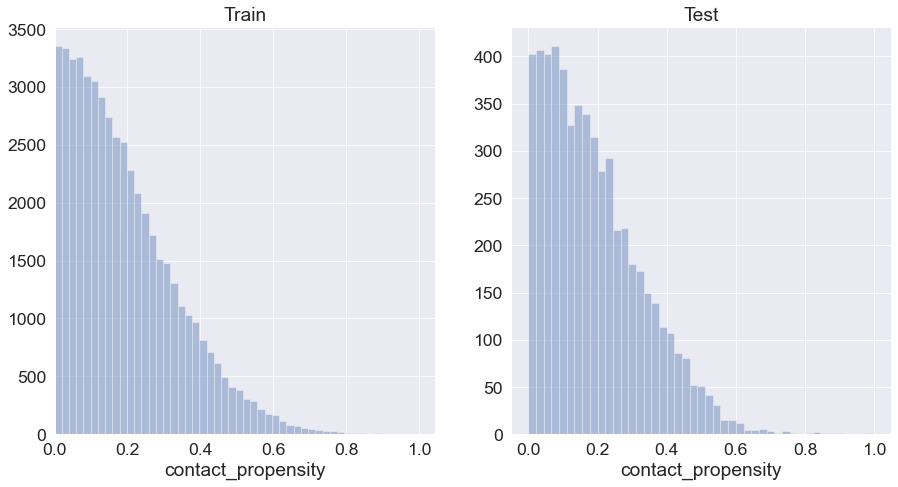

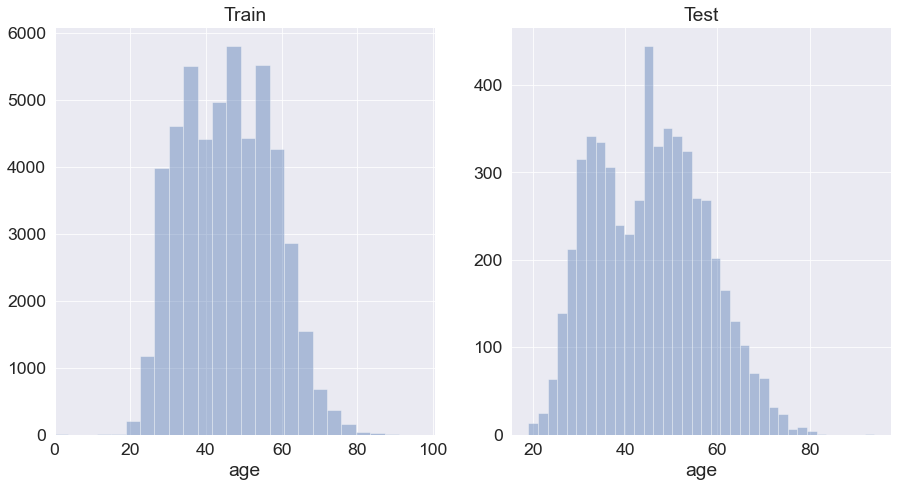

In [14]:
def probabilitydensity(train_data, test_data, x):
    """
    plots probability density for test and train data side by side
    train_data: pandas data frame (test or train)
    test_data: pandas data frame (test or train)
    title: title of plot, as str
    x: analysis vairable should be name of column with type object
    """

    x_col = train_data[x]
    x2_col = test_data[x]

    sns.set_style(style="darkgrid")
    sns.color_palette("pastel")
    sns.set_context("paper", font_scale=2)

    # Set frame of two plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))

    # Generate two count plots on the same frame
    sns.distplot(x_col, ax=ax[0], kde=False)
    sns.distplot(x2_col, ax=ax[1], kde=False)

    # Label give each plot a title
    ax[0].set_title("Train")
    ax[1].set_title("Test")

    # Label x axis
    ax[0].set_xlabel(x)
    ax[1].set_xlabel(x)

    # Set 0 bottom limit for train axis to deal with weird plotting nuance
    ax[0].set(xlim=0)
    plt.savefig(x)

    plt.show()


# Plot probability density
train_data = train
test_data = test

# Plot for contact propensity
x = "contact_propensity"
probabilitydensity(train_data, test_data, x)

# Plot for age
x = "age"
probabilitydensity(train_data, test_data, x)

# Feature Engineering 
Models interpret numbers, therefore all categorical feature will need to be encoded. I have used OneHotEncoder to convert\
categorical features to numeric features that are model interpretable.


In [15]:
import sklearn
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder


# Wrapper for OneHotEncoder that returns a labelled data frame after transform method is applied
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(
            sparse_matrix.toarray(), columns=new_columns, index=X.index
        )
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f"{column}_<{self.categories_[i][j]}>")
                j += 1
        return new_columns


def transform(Train, df):

    """
    Transforms categorical features to One Hot Encoded features
    and generates data set with those features and numeric features

    Train: The training data set which should be a pandas data frame
    It's required to initialise the OHE object

    df: The data set that you want to be transformed. This should be
    either training or testing.


    """
    # split out customer ids
    Train_id = Train[["customer_id"]].copy()
    df_id = df[["customer_id"]].copy()

    # drop customer ids
    Train2 = Train.drop(columns="customer_id").copy()
    df2 = df.drop(columns="customer_id").copy()

    # Isolate categorical features
    cat_columns = df2.select_dtypes(include=["object"]).columns
    cat_df = df2[cat_columns]

    # Isolate the numeric features
    numeric_df = df2.select_dtypes(include=np.number)

    # Initialise one hot encoder object spcify handle unknown and auto options to keep test and train same size
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    # Fit the endcoder to training data
    ohe.fit(Train2[cat_columns])

    # Transform input data
    df_processed = ohe.transform(cat_df)

    # concatinate numeric features from orginal tables with encoded features
    df_processed_full = pd.concat(
        [df_id, pd.concat([df_processed, numeric_df], axis=1)], axis=1
    )

    return df_processed_full


# Transform data

test_transformed = transform(train, test)
train_transformed = transform(train, train)

In [16]:
pd.set_option("display.max_columns", None)
train_transformed.head()

,customer_id,gender_<F>,gender_<M>,gender_<U>,country_name_<Canada>,country_name_<Germany>,country_name_<New Zealand>,country_name_<United Kingdom>,country_name_<United States>,join_month_<April>,join_month_<August>,join_month_<December>,join_month_<February>,join_month_<January>,join_month_<July>,join_month_<June>,join_month_<March>,join_month_<May>,join_month_<November>,join_month_<October>,join_month_<September>,age,contact_propensity,churn_flag,join_year
0,WR10000922,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32,0.187192,1.0,2019
1,WR10002062,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,32,0.134550,0.0,2020
2,WR10025005,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,48,0.373612,0.0,2020
3,WR10021250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,58,0.412441,0.0,2020
4,WR10001138,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,30,0.007534,1.0,2018


In [17]:
# Specify x_train and Y_train
x_train = train_transformed.drop(columns=["customer_id", "churn_flag"])
Y_train = train_transformed["churn_flag"]

# Modelling: Training

I have built 4 prototype models using Grid Search and 5 fold cross validation for hyperparameter tuning.

1) Decision Tree
2) Lgostic Regression
3) Random Forest
4) Gradient Boosted Classifier


In [18]:
# Define a machine learning pipline with k-fold crossvalidation and gridsearch
from sklearn.model_selection import GridSearchCV


def model_pipeline(model, param_grid, x_train, Y_train):

    """
    Pipeline to train sklearn model using k-fold
    cross validation and grid search

    returns the best model and results for all
    traning runs

    parameters -
    model: an sklearn machine learning model
    param_gird: search space for grid search as dict

    """

    # Initialisa model with GridSearchCV or just GridSearch

    Tuned_Model = GridSearchCV(
        estimator=model, param_grid=param_grid, scoring="roc_auc", cv=5
    )

    # Fit model & Time the process for training the model
    print("Training Model")
    start_time = time.process_time()

    Tuned_Model.fit(x_train, Y_train)

    print("Finished training model")

    # End of fit time
    print(time.process_time() - start_time, "Seconds")

    return Tuned_Model, pd.DataFrame(Tuned_Model.cv_results_)

In [19]:
# Model 1: Logistic Regression

# Train and test a logistic regression model
from sklearn.linear_model import LogisticRegression

# Initialise the random forest model
model = LogisticRegression(penalty="l2", solver="liblinear", class_weight="balanced")
# Set paramters for Grid Search
param_grid = {"C": [0.001, 0.01, 0.1, 1], "fit_intercept": [True, False]}

# Train model and get results
Tuned_LogReg, Results_LogReg = model_pipeline(model, param_grid, x_train, Y_train)

Results_LogReg

Training Model
Finished training model
4.59375 Seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.117301,0.034417,0.009683,0.001067,0.001,True,"{'C': 0.001, 'fit_intercept': True}",0.719472,0.713957,0.719294,0.710666,0.712517,0.715181,0.003586,7
1,0.084567,0.006081,0.008980,0.000013,0.001,False,"{'C': 0.001, 'fit_intercept': False}",0.719469,0.713955,0.719292,0.710663,0.712515,0.715179,0.003586,8
2,0.115188,0.006693,0.009129,0.001079,0.01,True,"{'C': 0.01, 'fit_intercept': True}",0.726876,0.722329,0.724203,0.719246,0.718689,0.722269,0.003064,5
3,0.103733,0.009695,0.008785,0.000986,0.01,False,"{'C': 0.01, 'fit_intercept': False}",0.726865,0.722319,0.724191,0.719233,0.718677,0.722257,0.003064,6
4,0.115966,0.025580,0.008616,0.001009,0.1,True,"{'C': 0.1, 'fit_intercept': True}",0.728016,0.723585,0.724985,0.720910,0.718841,0.723267,0.003186,3
5,0.077860,0.015084,0.007443,0.001408,0.1,False,"{'C': 0.1, 'fit_intercept': False}",0.727922,0.723492,0.724891,0.720818,0.718753,0.723175,0.003184,4
6,0.095925,0.008105,0.006404,0.000760,1,True,"{'C': 1, 'fit_intercept': True}",0.729362,0.724942,0.726277,0.722353,0.720132,0.724613,0.003182,1
7,0.099517,0.014109,0.006449,0.001005,1,False,"{'C': 1, 'fit_intercept': False}",0.728522,0.724058,0.725440,0.721464,0.719212,0.723739,0.003211,2


In [20]:
# Model 2: Decision Tree

# Train a decision tree
from sklearn.tree import DecisionTreeClassifier

# Initialise the random forest model
model = DecisionTreeClassifier(criterion="gini", class_weight="balanced")
# Set paramters for Grid Search
param_grid = {
    "max_depth": [5, 10, 30],
    "max_features": [0.1, 0.3, 0.7],
    "ccp_alpha": [0, 0.005, 0.01, 0.1],
}

# Train model and get results
Tuned_DecTree, Results_DecTree = model_pipeline(model, param_grid, x_train, Y_train)

Results_DecTree

Training Model
Finished training model
11.109375 Seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025728,0.001156,0.005392,0.000489,0,5,0.1,"{'ccp_alpha': 0, 'max_depth': 5, 'max_features...",0.701269,0.808006,0.625331,0.689160,0.716199,0.707993,0.058827,26
1,0.034982,0.002991,0.005783,0.000399,0,5,0.3,"{'ccp_alpha': 0, 'max_depth': 5, 'max_features...",0.927283,0.823009,0.915534,0.907883,0.912334,0.897209,0.037652,14
2,0.057848,0.018881,0.006381,0.001015,0,5,0.7,"{'ccp_alpha': 0, 'max_depth': 5, 'max_features...",0.962603,0.980136,0.985071,0.978633,0.983524,0.977993,0.008032,2
3,0.033708,0.004900,0.006178,0.000754,0,10,0.1,"{'ccp_alpha': 0, 'max_depth': 10, 'max_feature...",0.926777,0.912164,0.797170,0.892631,0.907678,0.887284,0.046355,16
4,0.047004,0.005913,0.005784,0.000399,0,10,0.3,"{'ccp_alpha': 0, 'max_depth': 10, 'max_feature...",0.925162,0.973829,0.977756,0.969090,0.928701,0.954908,0.023034,7
5,0.076221,0.005374,0.005591,0.000507,0,10,0.7,"{'ccp_alpha': 0, 'max_depth': 10, 'max_feature...",0.987100,0.985813,0.988648,0.987417,0.986866,0.987169,0.000915,1
6,0.051804,0.015231,0.008008,0.001891,0,30,0.1,"{'ccp_alpha': 0, 'max_depth': 30, 'max_feature...",0.916194,0.913533,0.891787,0.909384,0.917053,0.909590,0.009294,12
7,0.066030,0.004933,0.007379,0.001017,0,30,0.3,"{'ccp_alpha': 0, 'max_depth': 30, 'max_feature...",0.937210,0.932685,0.929166,0.934837,0.933551,0.933490,0.002646,11
8,0.096947,0.006935,0.006776,0.000968,0,30,0.7,"{'ccp_alpha': 0, 'max_depth': 30, 'max_feature...",0.935484,0.932955,0.932049,0.940024,0.933809,0.934864,0.002817,10
9,0.026151,0.002477,0.006989,0.001275,0.005,5,0.1,"{'ccp_alpha': 0.005, 'max_depth': 5, 'max_feat...",0.656623,0.578690,0.563295,0.815719,0.637658,0.650397,0.089734,29


In [21]:
# Model 3: Random Forest

# Train a random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Initialise the random forest model
model = RandomForestClassifier(class_weight="balanced_subsample", bootstrap=True)

# Set paramters for Grid Search
param_grid = {
    "n_estimators": [200, 300, 400, 500, 600],
    "max_features": [0.1, 0.3, 0.6],
}

# Train model and get results
Tuned_RandomForest, Results_RandForest = model_pipeline(
    model, param_grid, x_train, Y_train
)

Results_RandForest

Training Model
Finished training model
1015.171875 Seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.193962,0.343713,0.305849,0.012995,0.1,200,"{'max_features': 0.1, 'n_estimators': 200}",0.990364,0.989631,0.988956,0.988930,0.988833,0.989342,0.000584,15
1,7.587944,0.374323,0.463489,0.051297,0.1,300,"{'max_features': 0.1, 'n_estimators': 300}",0.990145,0.989706,0.989215,0.988823,0.988832,0.989344,0.000514,14
2,10.376854,0.651400,0.584385,0.021354,0.1,400,"{'max_features': 0.1, 'n_estimators': 400}",0.990205,0.989848,0.989411,0.988861,0.989009,0.989467,0.000504,13
3,11.806823,0.037850,0.709342,0.002537,0.1,500,"{'max_features': 0.1, 'n_estimators': 500}",0.990362,0.989833,0.989239,0.988951,0.989020,0.989481,0.000539,12
4,14.225122,0.098935,0.852308,0.004030,0.1,600,"{'max_features': 0.1, 'n_estimators': 600}",0.990293,0.989843,0.989288,0.989005,0.989003,0.989486,0.000507,11
5,5.761718,0.026319,0.224009,0.002587,0.3,200,"{'max_features': 0.3, 'n_estimators': 200}",0.992645,0.992484,0.992128,0.992135,0.991947,0.992268,0.000256,10
6,8.702444,0.082632,0.334623,0.003092,0.3,300,"{'max_features': 0.3, 'n_estimators': 300}",0.992536,0.992641,0.992050,0.992448,0.991942,0.992323,0.000276,9
7,11.646264,0.254665,0.448948,0.020403,0.3,400,"{'max_features': 0.3, 'n_estimators': 400}",0.992901,0.992603,0.992124,0.992314,0.992051,0.992399,0.000316,7
8,14.323334,0.086316,0.553316,0.007003,0.3,500,"{'max_features': 0.3, 'n_estimators': 500}",0.992624,0.992434,0.992204,0.992316,0.992243,0.992364,0.000152,8
9,17.361902,0.078072,0.661545,0.004390,0.3,600,"{'max_features': 0.3, 'n_estimators': 600}",0.992867,0.992585,0.992357,0.992331,0.992375,0.992503,0.000203,6


In [22]:
# Model 4: Gradient Boosting Machines Classifier

# Train a GBM classifier
from sklearn.ensemble import GradientBoostingClassifier

# Initialise the random forest model
model = GradientBoostingClassifier()

# Set paramters for Grid Search
param_grid = {
    "n_estimators": [300],
    "max_depth": [5, 10, 30],
    "learning_rate": [0.01, 0.05, 0.1],
}

# Train model and get results
Tuned_GBM, Results_GBM = model_pipeline(model, param_grid, x_train, Y_train)

Results_GBM

Training Model
Finished training model
1962.109375 Seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.226211,0.201303,0.072225,0.001831,0.01,5,300,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.991159,0.991387,0.990667,0.991378,0.989678,0.990854,0.000643,6
1,35.572982,0.955510,0.149795,0.004552,0.01,10,300,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.993472,0.992942,0.992848,0.992970,0.991652,0.992777,0.000603,4
2,77.510612,1.201872,0.203947,0.002938,0.01,30,300,"{'learning_rate': 0.01, 'max_depth': 30, 'n_es...",0.974507,0.979716,0.968162,0.960521,0.946332,0.965848,0.011678,8
3,15.286378,0.032278,0.065806,0.001399,0.05,5,300,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.994692,0.994116,0.993829,0.994054,0.993465,0.994031,0.000402,1
4,36.181448,0.107535,0.147833,0.009202,0.05,10,300,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.993639,0.992782,0.992798,0.993234,0.992545,0.992999,0.000389,3
5,83.236439,4.878502,0.208003,0.005341,0.05,30,300,"{'learning_rate': 0.05, 'max_depth': 30, 'n_es...",0.949867,0.960955,0.955432,0.951531,0.951581,0.953873,0.003984,9
6,15.267323,0.038973,0.061878,0.000895,0.1,5,300,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.994383,0.994078,0.993731,0.994034,0.993231,0.993891,0.000390,2
7,35.798812,0.121203,0.132478,0.004750,0.1,10,300,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.993283,0.992394,0.992798,0.992976,0.992260,0.992742,0.000375,5
8,72.297573,7.072519,0.183212,0.012903,0.1,30,300,"{'learning_rate': 0.1, 'max_depth': 30, 'n_est...",0.990399,0.989580,0.988181,0.988618,0.988574,0.989070,0.000808,7


# Modelling: Evaluate Results

Evaluate model results with AUC at each test fold 

In [23]:
# Transform and compile model results


def bestmodel(data, modelname):

    """
    Function geneates best results from each model training
    run.
    data: model result as pandas data frame (from GridSearchCv)
    modelname: name of model used as str

    """

    bestmodel = data.loc[data.rank_test_score == 1].copy()
    bestmodel["score"] = "AUC"
    keep = [
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
        "split3_test_score",
        "split4_test_score",
        "score",
    ]
    bestmodel_a = bestmodel[keep].copy()
    bestmodel_a.set_index("score", inplace=True)
    bestmodel_b = bestmodel_a.T
    bestmodel_b["model"] = modelname
    bestmodel_c = dict(bestmodel_b)
    return bestmodel_b


# Set up lists of model results and model names
data = [Results_DecTree, Results_RandForest, Results_GBM]
modelname = ["DecTree", "RandForest", "GBM"]
allbestmodels = pd.DataFrame()

# Lopp through list of models and model names
for df, model in zip(data, modelname):
    mod = bestmodel(df, model)

    # concatenate into single table
    allbestmodels = pd.concat([allbestmodels, mod], axis=0)

# Reset index for plotting
allbestmodels.reset_index(inplace=True)

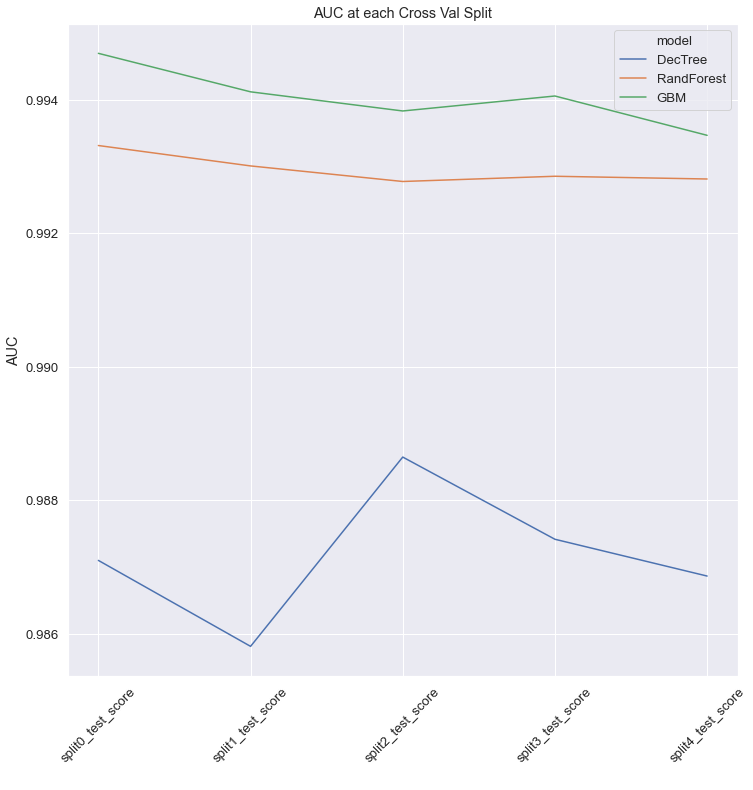

In [24]:
# Plot gendr distirbutions accross churn flags
sns.set(font_scale=1.2)
sns.set_style("darkgrid")
plt.figure(figsize=(12, 12))
ax = sns.lineplot(
    y=allbestmodels["AUC"],
    x=allbestmodels["index"],
    hue=allbestmodels["model"],
    ci="sd",
)
ax.tick_params(axis="x", labelrotation=45)
ax.set_title("AUC at each Cross Val Split")
ax.set_xlabel(" ")
plt.savefig("ModelEval")
plt.show()


# Predict
Predict churn flag using best two models GBM and RandomForest

In [27]:
# Predict Training Data Using GBM
x_test = test_transformed.drop(columns=["customer_id", "churn_flag"]).copy()
predictions = test.copy()
predictions = predictions.drop(columns=["churn_flag", "customer_id"])
predictions["churn_flag_gbm"] = Tuned_GBM.predict(x_test)

# Predict Training Data Using Random Forest
predictions["churn_flag_randfor"] = Tuned_RandomForest.predict(x_test)

# Output predictions to CSV
predictions.to_csv(r"Predictions_Final.csv")

In [26]:
# End of fit time
print("Script run time end to end")
print(time.process_time() - script_start_time, "Seconds")

Script run time end to end
2999.0 Seconds
